Loading some usefull modules used throughout this notebook

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas_datareader as pdr
import datetime



# Configuration for plots

In [2]:
font = {'weight' : 'normal',
        'size'   : 15}
mpl.rcParams['figure.figsize'] = (6., 6.0)
mpl.rc('font', **font)
mpl.rcParams['axes.unicode_minus']=False
mpl.rc('axes', linewidth = 1.5)
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['xtick.major.size'] = 5.5     # major tick size in points
mpl.rcParams['xtick.major.width'] = 1.5     # major tick size in points
mpl.rcParams['ytick.major.size'] = 5.5     # major tick size in points
mpl.rcParams['ytick.major.width'] = 1.5     # major tick size in points

# Exploring data with pandas

In [9]:
!head 4708263_QB3Z8L4T.csv

In [10]:
stock_A = df=pd.read_csv('4708263_FGA0ZWBR.csv',index_col='timestamp',header=0,parse_dates=True)
stock_B = df=pd.read_csv('4708263_QB3Z8L4T.csv',index_col='timestamp',header=0,parse_dates=True)

<AxesSubplot:ylabel='Frequency'>

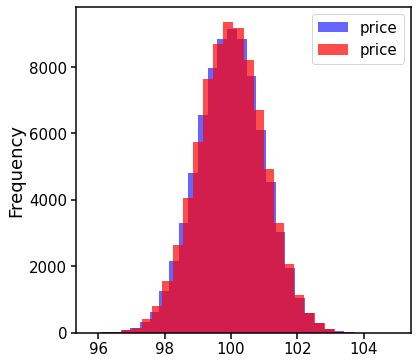

In [23]:
fig,ax= plt.subplots()
stock_A.plot(kind='hist',bins=30,ax=ax,alpha=0.6,color='b')
stock_B.plot(kind='hist',bins=30,ax=ax,alpha=0.7,color='r')

Both stock price seem to be normally distributed

In [33]:
# what is the total time 
print ('total time for stock A:', stock_A.index[-1] - stock_A.index[0])
print ('total time for stock B:', stock_B.index[-1] - stock_B.index[0])
# Ok this is stock data over a period of 14 hours, and the same
# applies for stock B

total time for stock A: 0 days 13:59:57.562772036
total time for stock B: 0 days 13:59:57.733971734


# Implementing the trading algorithm

In [257]:
# Ok add column to stock dataframe that signals a trade and initialize to zero
# first case: lets analyze stock A
cond = 4 # condition to signal a trading opportunity
delay = 40 # [ms] trading lag between stock A and stock B

signal = pd.DataFrame(index = stock_A.index).fillna(0)
signal['pricediffA'] = stock_A.diff()
signal['trade signal']= 0

# Now we buy or sell stock B whenever tradesignal is 1 or -1, respectively
signal.loc[signal.pricediffA > cond,'trade signal']= 1 # Buy stock B
signal.loc[signal.pricediffA < -cond,'trade signal']= -1 # Sell stock B

# keep track of all the B stocks that have been bought and sold
holding_B = pd.DataFrame(index=stock_B.index)
holding_B['price']= stock_B.price
holding_B['buysignal'] = 0
holding_B['sellsignal'] = 0

# now get all the buy signals indices
buy_B_ind = signal.index[(signal['trade signal']==1)]
# add 40 ms for delay
buy_B_ind += datetime.timedelta(milliseconds=delay)

# now check the nearest time stamp in B. The 'nearest' variable 
# finds the lower timestamp in B
for buy in buy_B_ind:
    
    # find nearest time in B
    ind = stock_B.index.get_loc(buy, method='nearest')
    timest_buy = stock_B.index[ind] # buy after 40 ms
    # After buying stock B, sell at the next time step to make profit
    # only if value at next time step is larger
    timest_sell = stock_B.index[ind+1] #
    
    # perform check to signal profit trade
    if (holding_B.loc[timest_buy]['price'] < holding_B.loc[timest_sell]['price']):
        # we make profit
        holding_B.at[timest_buy,'buysignal']= -1 # negative, because capital leaves our wallet
        holding_B.at[timest_sell,'buysignal']= 1 # positive, because capital enters our wallet


# Now do the same for when value of stock price decrease is larger than c 

sell_B_ind = signal.index[(signal['trade signal']==-1)]
# add 40 ms for delay
sell_B_ind += datetime.timedelta(milliseconds=delay)

# now check the nearest time stamp in B. The 'nearest' variable 
# finds the lower timestamp in B
for sell in sell_B_ind:
    
    # find nearest time in B
    ind = stock_B.index.get_loc(sell, method='nearest')
    timest_sell = stock_B.index[ind] # sell B after 40 ms
    # After selling stock B, buy at the next time step to make profit
    # only if value at next time step is smaller
    timest_buy = stock_B.index[ind+1] #
    
    # perform check to signal profit trade only if buy price is lower than sell price
    if (holding_B.loc[timest_buy]['price'] < holding_B.loc[timest_sell]['price']):
        # we make profit
        holding_B.at[timest_sell,'sellsignal']= 1
        holding_B.at[timest_buy,'sellsignal']= -1
    


# Now calculate total profit after executing trades
holding_B['profit_buy'] = holding_B.buysignal * holding_B.price
holding_B['profit_sell'] = holding_B.sellsignal * holding_B.price

# sum columns to obtain the profits from selling and buying stock whenever the 
# price change of stock A is greater or smaller that 4 and -4, respectively

totalprofit = holding_B.profit_buy.sum() + holding_B.profit_sell.sum()

<AxesSubplot:xlabel='timestamp'>

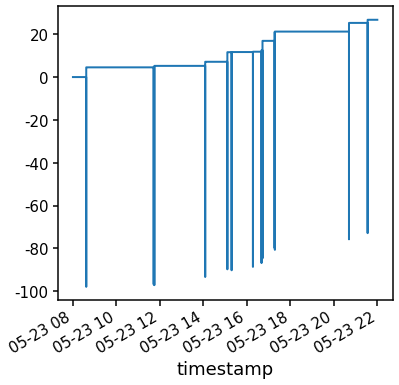

In [258]:
holding_B.profit_buy.cumsum().plot()

Trade execution: We indeed see that the code executes buy trades for stock B

<AxesSubplot:xlabel='timestamp'>

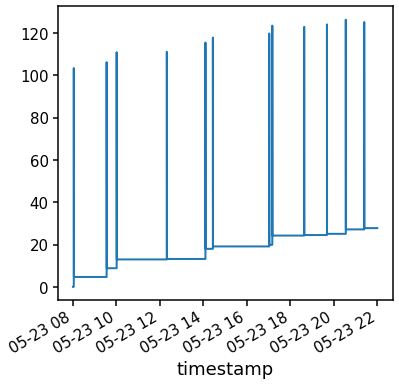

In [259]:
holding_B.profit_sell.cumsum().plot()

In [262]:
a = holding_B.profit_buy.cumsum() + holding_B.profit_sell.cumsum()

<AxesSubplot:xlabel='timestamp'>

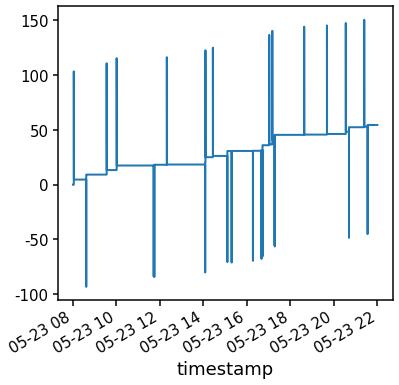

In [263]:
a.plot()

In [264]:
totalprofit

54.494270170838504